In [51]:
# Notwendige Bibliotheken importieren
import glob
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import csv
import random
import streamlit as st
import matplotlib.pyplot as plt
import numpy as np
import tsfresh

# Funktion zum Einlesen der CSV-Dateien
df_Water = pd.read_csv('Water.csv')
df_Knocking = pd.read_csv('Knocking.csv')
df_Water.drop(['time'], axis=1, inplace=True)
df_Knocking.drop(['time'], axis=1, inplace=True)

# Label hinzufügen
df_Water['Label'] = 'Water'
df_Knocking['Label'] = 'Knocking'


# TODO: Checke ob hierdurch Informationsverlust
# Auf ganze Zahl runden
df_Water['dBFS'] = df_Water['dBFS'].round(decimals = 0)
df_Knocking['dBFS'] =  df_Knocking['dBFS'].round(decimals = 0)


# Daten in einzelne Samples aufteilen
def split_dataframe(dataframe, length, num_frames, max_attempts=100):
    num_rows = len(dataframe)
    dataframes = []
    unique_ids = set()
    attempts = 0

    while len(dataframes) < num_frames and attempts < max_attempts:
        max_start_idx = num_rows - length
        if max_start_idx < 0:
            break

        start_idx = random.randint(0, max_start_idx)
        end_idx = start_idx + length

        if end_idx > num_rows:
            start_idx = num_rows - length

        # Create a new DataFrame slice
        df_slice = dataframe.iloc[start_idx:end_idx].copy()

        # Generate a unique ID for the DataFrame slice
        df_id = hash(df_slice.to_string())

        # Check for duplicates
        if df_id in unique_ids:
            attempts += 1
            continue

        # Add the DataFrame to the list and set
        dataframes.append(df_slice)
        unique_ids.add(df_id)
        attempts = 0

    return dataframes

split_Water = split_dataframe(df_Water, 100, 2000)
split_Knocking = split_dataframe(df_Knocking, 100, 2000)
print(len(split_Knocking))

#split_Water = np.array_split(df_Water, len(df_Water)/20-1)
#split_Knocking = np.array_split(df_Knocking, len(df_Knocking)/20-1)


2000


In [52]:
# Zusammenführen der beiden Dataframes (noch Water hinten und Knock vorne)

combined_df = []

features = pd.DataFrame()
#Feature-Enineering

for i in split_Knocking:
    combined_df.append(pd.DataFrame({"dBFS_Varianz": i["dBFS"].var(),"dBFS_STD" : i["dBFS"].std(), "dBFS_mean" : i["dBFS"].mean(),
    "dBFS_min" : i["dBFS"].min(), "dBFS_max" : i["dBFS"].max(), "dBFS_absMax" : i["dBFS"].abs().max(), "dBFS_sum" : i["dBFS"].sum(), "dBFS_median" : i["dBFS"].median(), "Label" : i["Label"]}))
        
for i in split_Water:
    combined_df.append(pd.DataFrame({"dBFS_Varianz": i["dBFS"].var(),"dBFS_STD" : i["dBFS"].std(), "dBFS_mean" : i["dBFS"].mean(),
    "dBFS_min" : i["dBFS"].min(), "dBFS_max" : i["dBFS"].max(), "dBFS_absMax" : i["dBFS"].abs().max(), "dBFS_sum" : i["dBFS"].sum(), "dBFS_median" : i["dBFS"].median(), "Label" : i["Label"]}))
      

In [53]:
combined_df[0].head(1)
final = []
for x in combined_df:

    final.append(x.head(1))

In [54]:
df_final = pd.concat(final)
df_final

,dBFS_Varianz,dBFS_STD,dBFS_mean,dBFS_min,dBFS_max,dBFS_absMax,dBFS_sum,dBFS_median,Label
2468,1810.611212,42.551277,-66.43,-122,0,122,-6643,-77.5,Knocking
2900,1572.930404,39.660187,-65.67,-120,0,120,-6567,-83.5,Knocking
983,1773.444343,42.112283,-61.49,-120,0,120,-6149,-70.5,Knocking
2655,1676.676667,40.947242,-65.51,-123,0,123,-6551,-73.5,Knocking
3864,1510.914747,38.870487,-52.12,-114,0,114,-5212,-58.5,Knocking
...,...,...,...,...,...,...,...,...,...
69,1772.110202,42.096439,-76.47,-121,0,121,-7647,-97.5,Water
2711,1560.108586,39.498210,-58.35,-120,0,120,-5835,-65.0,Water
2011,1244.492424,35.277364,-69.65,-115,-1,115,-6965,-84.5,Water
4765,1496.414545,38.683518,-48.36,-119,0,119,-4836,-45.0,Water


In [55]:
# Aufteilen der Daten in Trainings- und Testdaten
x = df_final.drop(columns = ["Label"])
y = df_final["Label"]
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Erstelle den KNN-Klassifikator
knn = RandomForestClassifier()

# Trainiere den Klassifikator
knn.fit(X_train, y_train)

# Vorhersagen für die Testdaten machen
y_pred = knn.predict(X_test)

# Bewertung der Genauigkeit des Klassifikators
accuracy = accuracy_score(y_test, y_pred)
x_ = classification_report(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
print('Genauigkeit:', accuracy)
print('Präzision:', precision)
print('Recall:', recall)
print('Neu:', x_)


# Berechne die Konfusionsmatrix
cm = confusion_matrix(y_test, y_pred)

# Gib die Konfusionsmatrix aus
print('Konfusionsmatrix:')
print(cm)

print(y_pred)

Genauigkeit: 0.3425
Präzision: 0.34448130209506644
Recall: 0.3425
Neu:               precision    recall  f1-score   support

    Knocking       0.37      0.33      0.35       422
       Water       0.32      0.35      0.34       378

    accuracy                           0.34       800
   macro avg       0.34      0.34      0.34       800
weighted avg       0.34      0.34      0.34       800

Konfusionsmatrix:
[[141 281]
 [245 133]]
['Water' 'Water' 'Knocking' 'Knocking' 'Knocking' 'Water' 'Water' 'Water'
 'Water' 'Water' 'Water' 'Water' 'Water' 'Water' 'Knocking' 'Knocking'
 'Knocking' 'Knocking' 'Water' 'Water' 'Water' 'Water' 'Water' 'Water'
 'Knocking' 'Water' 'Water' 'Water' 'Knocking' 'Water' 'Knocking'
 'Knocking' 'Knocking' 'Knocking' 'Water' 'Water' 'Water' 'Water' 'Water'
 'Knocking' 'Knocking' 'Knocking' 'Water' 'Water' 'Water' 'Knocking'
 'Water' 'Water' 'Knocking' 'Knocking' 'Water' 'Knocking' 'Water'
 'Knocking' 'Water' 'Water' 'Knocking' 'Water' 'Knocking' 'Water'
 'Kn

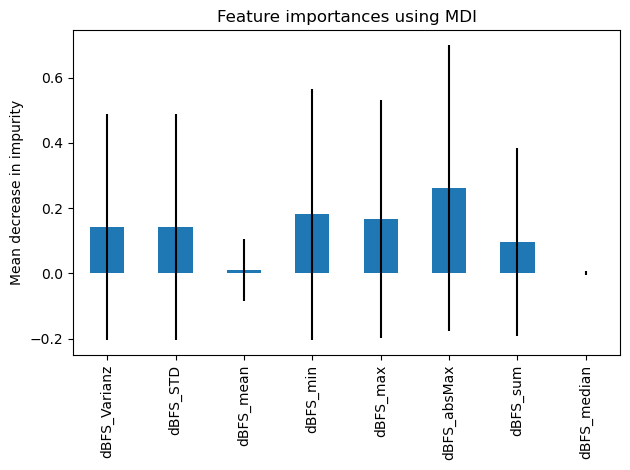

In [39]:
importance = knn.feature_importances_
std = np.std([tree.feature_importances_ for tree in knn.estimators_], axis=0)

forest_importances = pd.Series(importance, x.keys())

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)

ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()